**Lesson: M909 ΒΑΘΙΑ ΜΑΘΗΣΗ ΜΕ ΕΦΑΡΜΟΓΕΣ ΣΕ ΓΛΩΣΣΙΚΑ ΔΕΔΟΜΕΝΑ**

**Master's Program: Language Technology**

**Assignments 2 & 3**


**SENTIMENT ANALYSIS OF THE IMDB DATASET**

The IMDB Dataset consists of 50K movie reviews. The aim of these assignments is to apply different neural network architectures for classifying whether a review is positive or negative. 

Neural network architectures used in this project: 
*   Recurrent Neural Network with LSTM cells
*   Convolutional Neural Network
*   Pre-trained model from Hugging Face (DistilBert)

The RNN and CNN models were trained 2 times each: 
*   one with the embedding layer frozen during training 
*   one using the 100-dimensional pre-trained Glove embeddings 

This project consists of 7 parts:
* Load the data
* Preprocess the data and split
* Build the vocabulary
* Training and evaluation of models without Glove pre-trained embeddings (frozen embeddings)
* Training and evaluation of models with Glove pre-trained embeddings 
* Use a model from Hugging Face and fine tune it on the IMDB dataset
* Presenting the results from the models

**DOWNLOAD AND IMPORT NECESSARY PACKAGES AND LIBRARIES**

In [2]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.9 MB/s 
     |████████████████████████████████| 3.3 MB 37.0 MB/s 
     |████████████████████████████████| 596 kB 61.9 MB/s 
     |████████████████████████████████| 895 kB 57.3 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
# Import necessary libraries
import torch
from torchtext import data, datasets
import random
import re 
import spacy
import time
import matplotlib.pyplot as plt 
import pandas as pd  
import math
import numpy as np
import nltk
import numpy as np
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import collections
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset
import torch.nn as nn
import torchtext
from torchtext.legacy import data
import torchtext.legacy
import torch.nn.functional as F
import torch.optim as optim
import os
from sklearn.model_selection import train_test_split
from transformers import EarlyStoppingCallback
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Download necessary packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
# Download the IMDB Dataset and unzip it to a new folder
URL = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
# Download Datasets
!wget -P 'Data/' $URL
# Unzip
!tar xvzf 'Data/aclImdb_v1.tar.gz' -C 'Data/'

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/uns

In [5]:
# Download and unzip the Glove pre-trained vectors in a new folder to use as embeddings
FILE = 'GLOVE'
URL = 'http://nlp.stanford.edu/data/glove.6B.zip'

!wget -P $FILE $URL
!unzip $FILE/glove*.zip -d $FILE

--2022-01-24 22:22:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-24 22:22:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-24 22:22:51--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘GLOVE/glove.6B.zip’

g

**SET UP GPU FOR TRAINING**

In [6]:
# Set up GPU for Training
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Device name: Tesla T4


**FUNCTIONS USED**

In [7]:
# A function that calculates the time needed for training and evaluation in each epoch
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [8]:
# A function that reads a set of files in a given directory and saves the lines to a list
# It takes as parameters:
# path: an absolute/relative path to a given file
# file_list: a list of files to read
# dataset: a list that stores the read lines
# The file encoding 
def load_data(path, file_list, dataset, encoding='utf8'):
    for file in file_list:
        with open(os.path.join(path, file), 'r', encoding=encoding) as text:
            dataset.append(text.read())

In [9]:
# A function that opens, reads a file in csv with utf-8 encoding, gets the values, checks and fills empty values and checks for duplicates
def read_explore_dataframe(dataframe):

  # Count the number of examples in each class
  print(dataframe.label.value_counts())
  print()
  
  # Get the keys and their corresponding number of values
  keys = dataframe.keys() 
  for key in keys:
    df_len = len(dataframe[key].unique()) # the length of the unique values of each column
    print('{0:25}{1:10}'.format(key,df_len))

  dataframe.dropna(inplace=True) # remove missing values and keep the dataFrame with valid entries in the same variable
  dataframe.reset_index(inplace=True,drop=True)

  dataframe.duplicated() # check for duplicates
  #print('Number of duplicates in the dataframe:', dataframe.duplicated().sum())
  print('Dataframe checked for NaN values and duplicates!')
  
  return dataframe 

In [10]:
# A function that takes as parameter a text and applies preprocessing steps to clean it
def text_preprocessing(text):
  
  # Remove tags
  TAG_RE = re.compile(r'<[^>]+>')
  no_tags = TAG_RE.sub('',text)  
                
  # Remove unusual characters
  text = re.sub('<[^>]*>', '', no_tags)

  # Remove urls
  text = re.sub(r'http\S+','', text)
    
  # Remove emoticons
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)

  # Remove punctuation
  no_punct = [word for word in emoticons if word.isalpha()]
                
  # Convert all words to lowercase
  text = re.sub('[\W]+', ' ', text.lower()) + " ".join(no_punct).replace('-', '')
    
  # Remove numbers
  no_numbers_txt = re.sub(r'\d+', '', text)

  # Tokenize
  tokens = nltk.word_tokenize(no_numbers_txt)

  # Filter out stopwords
  no_stopwords = [word for word in tokens if word not in stop_words_set]

  # Lemmatize
  lemmatizer = WordNetLemmatizer()
  lemmas = " ".join([lemmatizer.lemmatize(token) for token in no_stopwords])
  
  return lemmas

In [11]:
# A function that gets as input the dataframe and gets the necessary values from the columns after resampling and pre-processing
def get_columns(dataframe, feature, label):
  
  # Get only the columns we are interested in
  dataset = dataframe[[feature,label]]

  # Apply the pre-processing function to the dataframe containing the text (feature column)
  dataset[feature] = dataset[feature].apply(text_preprocessing)
  print('\nText done pre-processing!')

  # Divide the X and y values
  X = dataset[feature]
  y = dataset[label]

  # Split train dataset to train and validation set
  X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.20, random_state = 42)
  print('The dataset is split into training and validation sets!')
  
  print('Shape of x_train: ', X_train.shape)
  print('Shape of y_train: ', Y_train.shape)
  print('Shape of x_val:  ', X_val.shape)
  print('Shape of y_val:  ', Y_val.shape)

  # Concatenate the X,Y data of training and validation data 
  train = pd.concat([X_train, Y_train], axis=1)
  valid = pd.concat([X_val, Y_val], axis=1) 
   
  # Save the training and validation data into csv format
  train.to_csv("/content/train.csv", index=False)  
  valid.to_csv("/content/valid.csv", index=False)

  return train, valid

In [12]:
# A function that creates iterators for the given datasets
# In each batch, the sentences are transposed to be descending vertically 
# Each index represents a token and each column represents a sentence
# The batch size specifies the number of columns
# The lambda function finds sentences of the same length
 
def create_iterators(train_dataset, validation_dataset, test_dataset, batch_size):
  
  train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
  # The Datasets to load Examples from
  (train_dataset, validation_dataset, test_dataset), 
  # The batch size
  batch_size = batch_size,
  # Function to use for sorting examples
  sort_key = lambda x: len(x.Review),
  # Repeat the iterator for multiple epochs
  repeat = False,
  # Shuffle data on each epoch run
  shuffle = True,
  # Use 'sort_key' to sort examples in each batch
  sort_within_batch = True,
  
  device = device)
  
  return train_iterator, val_iterator, test_iterator

In [13]:
# A function that calculates the trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# A function that sets seed for reproducibility
def set_seed(seed_value): 
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [14]:
# ====== METRICS CALCULATION ======

# A function that calculates accuracy per batch and returns rounded predictions
def binary_accuracy(preds, y):
    
    # Round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() # Convert into float for division 
    acc = correct.sum() / len(correct)
    return acc


# A function that calculates all the metrics using the testing set
def calculate_metrics(y_true, preds):  
  
  print('\nCalculating metrics...')
  # Calculate the accuracy of the model 
  acc = accuracy_score(y_true, preds)
  # Calculate general precision, recall, F1 score of the model and of each class
  precision, recall, fscore, support = score(y_true, preds)
  print('Accuracy: {}'.format(acc))
  print('Precision: {}'.format(precision))
  print('Recall: {}'.format(recall))
  print('F1 score: {}'.format(fscore))
  print('Support: {}'.format(support))

  # Print classification report
  print(classification_report(y_true, preds))

In [15]:
# ====== TRAINING (TRAINING SET) ======
def train(model, iterator, optimizer, criterion, clip):
  
  training_loss = 0   
  training_acc = 0
    
  # Set model to training mode
  model.train()
   
  # For each batch in the training iterator
  for batch in tqdm(iterator):
   
    # Zero the gradients
    optimizer.zero_grad()
               
    # Compute the predictions
    predictions = model(batch.Review).squeeze(1)   
    
    # Compute the loss
    loss = criterion(predictions, batch.Label)
        
    # Compute the accuracy
    acc = binary_accuracy(predictions, batch.Label.float())
        
    # Use loss to compute gradients
    loss.backward()
    
    # Clip the gradient value
    nn.utils.clip_grad_norm_(model.parameters(), clip)
        
    # Use optimizer to take gradient step
    optimizer.step()
        
    training_loss += loss.item()
    training_acc += acc.item()
  
  loss_of_epoch = training_loss / len(iterator)
  accuracy_of_epoch = training_acc / len(iterator)
 
  # Return the loss and accuracy, averaged across each epoch
  # len of iterator = number of batches in the iterator
  return loss_of_epoch, accuracy_of_epoch

In [16]:
# ====== EVALUATION (VALIDATION SET) ======
def evaluate(model, iterator, criterion):
       
  eval_loss = 0
  eval_acc = 0
    
  # Set model to evaluation mode
  model.eval()
   
  # Don't calculate the gradients
  with torch.no_grad():
    
    for batch in tqdm(iterator):
     
      # Compute the predictions         
      predictions = model(batch.Review).squeeze(1)

      # Compute the loss    
      loss = criterion(predictions, batch.Label)

      # Compute the accuracy    
      acc = binary_accuracy(predictions, batch.Label.float())

      eval_loss += loss.item()
      eval_acc += acc.item()
        
  loss_of_epoch = eval_loss / len(iterator)
  accuracy_of_epoch = eval_acc / len(iterator)

  # Return the loss and accuracy, averaged across each epoch
  # len of iterator = number of batches in the iterator
  return loss_of_epoch, accuracy_of_epoch


# ====== EVALUATION (TESTING SET) ======
def testing(model, iterator):
    
  predictions_all = []
  labels_all = []
    
  model.eval() 
    
  with torch.no_grad(): 
    
    for batch in iterator:
      predictions = model(batch.Review).squeeze(1) 
      predictions_all +=  torch.round(torch.sigmoid(predictions)).flatten().cpu().numpy().tolist()       
      labels_all += batch.Label.flatten().cpu().numpy().tolist()
        
  return predictions_all, labels_all

**MODELS**

In [17]:
# ====== Recurrent Neural Network Model with LSTM ======
class LSTM_Model(nn.Module):
  
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, d_rate, pad_idx):
    
    super(LSTM_Model, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, dropout=d_rate)
    self.dense = nn.Linear(2 * hidden_dim, output_dim)
    self.dropout = nn.Dropout(d_rate)
    
  def forward(self, x):
    
    # Get the word embeddings of the batch
    # x: (sentence_length, batch_size)
    embedded = self.dropout(self.embedding(x))
    # embedded: (sentence_length, batch_size, embedding_dim)

    # Propagate the input through LSTM layer/s
    _, (hidden, _) = self.lstm(embedded)

    # Extract output of the last time step
    # Concat the final output of forward direction and backward direction
    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
    # hidden: (batch_size, hidden_dim * 2)

    output = self.dense(hidden)

    return output

In [18]:
# ====== Convolutional Neural Network Model ======
class CNN(nn.Module):
  
  def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx):
    super(CNN,self).__init__()
           
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)      
    
    # in_channels: the number of "channels" in the image going into the convolutional layer
    # out_channels: the number of filters
    # the kernel_size: the size of the filters. Each of the kernel_sizes is going to be [n x emb_dim] where n is the size of the n-grams   
    self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, out_channels = n_filters, kernel_size = (fs, embedding_dim)) for fs in filter_sizes])     
    
    self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)        
    self.dropout = nn.Dropout(dropout)
        
  def forward(self, text):
    
    #text = [sent len, batch size]
        
    text = text.permute(1, 0)
                
    #text = [batch size, sent len]
        
    embedded = self.dropout(self.embedding(text))
                
    #embedded = [batch size, sent len, emb dim]
        
    embedded = embedded.unsqueeze(1)
        
    #embedded = [batch size, 1, sent len, emb dim]
        
    conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
    #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
    #pooled_n = [batch size, n_filters]
        
    cat = self.dropout(torch.cat(pooled, dim = 1))

    #cat = [batch size, n_filters * len(filter_sizes)]
            
    return self.fc(cat)

**RUN THE SCRIPT - APPLY FUNCTIONS**

**PART 1: LOAD THE DATA**

In [19]:
set_seed(42)

# Path to dataset location
path = '/content/Data/aclImdb'

# Create lists that will contain read lines
train_pos, train_neg, test_pos, test_neg = [], [], [], []

# Create a dictionary of paths and lists that store lines (key: value = path: list)
sets_dict = {'train/pos/': train_pos, 'train/neg/': train_neg,
             'test/pos/': test_pos, 'test/neg/': test_neg}

# Load the data
for dataset in sets_dict:
        file_list = [f for f in os.listdir(os.path.join(path, dataset)) if f.endswith('.txt')]
        load_data(os.path.join(path, dataset), file_list, sets_dict[dataset])

# Concatenate positive and negative into datasets, one for the training and one for the testing
train_dataset = pd.concat([pd.DataFrame({'review': train_pos, 'label':1}), 
                          pd.DataFrame({'review': train_neg, 'label':0})],
                          axis=0, ignore_index=True)

test_dataset = pd.concat([pd.DataFrame({'review': test_pos, 'label':1}), 
                          pd.DataFrame({'review': test_neg, 'label':0})],
                          axis=0, ignore_index=True)             

In [20]:
train_dataset.head()

,review,label
0,Picture the classic noir story lines infused w...,1
1,"Sandra Bernhard's Without You I'm Nothing, the...",1
2,"Starring: Jim Carrey, Morgan Freeman, Jennifer...",1
3,"A typical Clausen film, but then again not typ...",1
4,"I had few problems with this film, and I have ...",1


**PART 2: PREPROCESS THE DATA AND SPLIT**

In [21]:
# ====== Prepare the datasets ======
print('------ Preparing the training and validation dataset... ------')

# Opens, reads, checks for duplicates and removes missing values
train_df = read_explore_dataframe(train_dataset)

# Gets the necessary columns, resamples, preprocesses the texts, splits into training and validation sets and saves them to csv
train_dataframe, valid_dataframe = get_columns(train_df, 'review', 'label')

------ Preparing the training and validation dataset... ------
1    12500
0    12500
Name: label, dtype: int64

review                        24904
label                             2
Dataframe checked for NaN values and duplicates!

Text done pre-processing!
The dataset is split into training and validation sets!
Shape of x_train:  (20000,)
Shape of y_train:  (20000,)
Shape of x_val:   (5000,)
Shape of y_val:   (5000,)


In [22]:
# ====== Prepare the datasets ======
print('------ Preparing the testing dataset... ------')

# Opens, reads, checks for duplicates and removes missing values
test_df = read_explore_dataframe(test_dataset)

# Apply the function for preprocessing the text 
test_df['review'] = test_df['review'].apply(text_preprocessing)
print('\nText done pre-processing!')

# Divide the text and the labels 
test_texts = test_df['review']
test_labels = test_df['label']

# Concatenate the text and labels of the clean dataset into a new dataframe
test_dataframe = pd.concat([test_texts, test_labels], axis=1)
  
# Save the testing data into csv format 
test_dataframe.to_csv("/content/test.csv", index=False)
print('The testing dataset is ready and saved into csv format!')

------ Preparing the testing dataset... ------
1    12500
0    12500
Name: label, dtype: int64

review                        24801
label                             2
Dataframe checked for NaN values and duplicates!

Text done pre-processing!
The testing dataset is ready and saved into csv format!


**PART 3: BUILD THE VOCABULARY**

In [23]:
# ====== Load the data & Build the vocabulary ======

set_seed(42)

# Create the TEXT and LABEL fields
TEXT = data.Field(tokenize = 'spacy', lower = True, sequential = True)
LABEL = data.LabelField(dtype = torch.float, sequential = False)

# Loading training, testing and validation data 
train_data, valid_data, test_data = data.TabularDataset.splits(
    path ='/content/', train = 'train.csv', 
    validation = 'valid.csv', test = 'test.csv', format = 'csv', skip_header = True, 
    fields = [('Review', TEXT), ('Label', LABEL)])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

# Build the vocabulary using the train data
TEXT.build_vocab(train_data, vectors = torchtext.vocab.Vectors('/content/GLOVE/glove.6B.100d.txt'), max_size = 25000, unk_init=torch.Tensor.normal_) 
LABEL.build_vocab(train_data)

print('\nTokens in TEXT vocabulary: {}'.format(len(TEXT.vocab)))
print('Tokens in LABEL vocabulary: {}'.format(len(LABEL.vocab)))

Number of training examples: 20000
Number of valid examples: 5000
Number of testing examples: 25000


100%|█████████▉| 399999/400000 [00:14<00:00, 27287.55it/s]



Tokens in TEXT vocabulary: 25002
Tokens in LABEL vocabulary: 2


In [24]:
print(TEXT.vocab.freqs.most_common(20))
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

[('movie', 41280), ('film', 37362), ('one', 22294), ('like', 16555), ('time', 12693), ('good', 12127), ('character', 11316), ('story', 10575), ('even', 10141), ('get', 10026), ('would', 9924), ('make', 9763), ('see', 9570), ('really', 9254), ('well', 8626), ('scene', 8465), ('much', 7791), ('bad', 7432), ('people', 7370), ('also', 7312)]
['<unk>', '<pad>', 'movie', 'film', 'one', 'like', 'time', 'good', 'character', 'story']
defaultdict(None, {'0': 0, '1': 1})


**PART 4: TRAINING AND EVALUATION OF MODELS WITHOUT GLOVE PRE-TRAINED EMBEDDINGS (FROZEN EMBEDDINGS)**

LSTM_Model(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (lstm): LSTM(100, 20, num_layers=2, dropout=0.5, bidirectional=True)
  (dense): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 2,529,681 trainable parameters



100%|██████████| 79/79 [00:00<00:00, 88.38it/s]


Epoch: 01 | Epoch Time: 0m 10s | Frozen: True
	Train Loss: 0.694 | Train Acc: 50.75%
	 Val. Loss: 0.691 |  Val. Acc: 55.18%


100%|██████████| 79/79 [00:00<00:00, 88.59it/s]


Epoch: 02 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.690 | Train Acc: 53.64%
	 Val. Loss: 0.684 |  Val. Acc: 66.04%


100%|██████████| 79/79 [00:00<00:00, 89.32it/s]


Epoch: 03 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.670 | Train Acc: 61.47%
	 Val. Loss: 0.598 |  Val. Acc: 70.06%


100%|██████████| 79/79 [00:00<00:00, 90.05it/s]


Epoch: 04 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.591 | Train Acc: 69.80%
	 Val. Loss: 0.592 |  Val. Acc: 70.51%


100%|██████████| 79/79 [00:00<00:00, 88.36it/s]


Epoch: 05 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.557 | Train Acc: 72.65%
	 Val. Loss: 0.537 |  Val. Acc: 73.52%


100%|██████████| 79/79 [00:00<00:00, 86.03it/s]


Epoch: 06 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.544 | Train Acc: 73.59%
	 Val. Loss: 0.504 |  Val. Acc: 76.29%


100%|██████████| 79/79 [00:00<00:00, 89.37it/s] 


Epoch: 07 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.538 | Train Acc: 74.22%
	 Val. Loss: 0.510 |  Val. Acc: 76.33%


100%|██████████| 79/79 [00:00<00:00, 90.60it/s]


Epoch: 08 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.527 | Train Acc: 74.91%
	 Val. Loss: 0.512 |  Val. Acc: 76.42%


100%|██████████| 79/79 [00:00<00:00, 87.91it/s]


Epoch: 09 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.527 | Train Acc: 74.92%
	 Val. Loss: 0.506 |  Val. Acc: 76.82%


100%|██████████| 79/79 [00:00<00:00, 89.97it/s] 


Epoch: 10 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.520 | Train Acc: 75.71%
	 Val. Loss: 0.488 |  Val. Acc: 78.42%


100%|██████████| 79/79 [00:00<00:00, 89.13it/s]


Epoch: 11 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.516 | Train Acc: 75.53%
	 Val. Loss: 0.484 |  Val. Acc: 78.05%


100%|██████████| 79/79 [00:00<00:00, 88.40it/s]


Epoch: 12 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.511 | Train Acc: 75.80%
	 Val. Loss: 0.478 |  Val. Acc: 78.70%


100%|██████████| 79/79 [00:00<00:00, 88.26it/s]


Epoch: 13 | Epoch Time: 0m 9s | Frozen: True
	Train Loss: 0.507 | Train Acc: 76.21%
	 Val. Loss: 0.468 |  Val. Acc: 79.11%


100%|██████████| 79/79 [00:00<00:00, 86.34it/s]


Epoch: 14 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.500 | Train Acc: 76.75%
	 Val. Loss: 0.463 |  Val. Acc: 79.00%


100%|██████████| 79/79 [00:00<00:00, 88.77it/s]


Epoch: 15 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.495 | Train Acc: 77.03%
	 Val. Loss: 0.464 |  Val. Acc: 78.70%


100%|██████████| 79/79 [00:00<00:00, 88.29it/s] 


Epoch: 16 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.494 | Train Acc: 76.97%
	 Val. Loss: 0.446 |  Val. Acc: 79.69%


100%|██████████| 79/79 [00:00<00:00, 87.61it/s]


Epoch: 17 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.486 | Train Acc: 77.64%
	 Val. Loss: 0.446 |  Val. Acc: 79.85%


100%|██████████| 79/79 [00:00<00:00, 87.36it/s]


Epoch: 18 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.484 | Train Acc: 77.52%
	 Val. Loss: 0.442 |  Val. Acc: 79.83%


100%|██████████| 79/79 [00:00<00:00, 89.67it/s]


Epoch: 19 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.478 | Train Acc: 78.08%
	 Val. Loss: 0.439 |  Val. Acc: 80.80%


100%|██████████| 79/79 [00:00<00:00, 88.11it/s]


Epoch: 20 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.476 | Train Acc: 77.96%
	 Val. Loss: 0.446 |  Val. Acc: 80.48%


100%|██████████| 79/79 [00:00<00:00, 87.82it/s] 


Epoch: 21 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.474 | Train Acc: 78.06%
	 Val. Loss: 0.436 |  Val. Acc: 81.37%


100%|██████████| 79/79 [00:00<00:00, 89.73it/s]


Epoch: 22 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.471 | Train Acc: 78.40%
	 Val. Loss: 0.434 |  Val. Acc: 81.51%


100%|██████████| 79/79 [00:00<00:00, 89.34it/s]


Epoch: 23 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.466 | Train Acc: 78.71%
	 Val. Loss: 0.440 |  Val. Acc: 81.19%


100%|██████████| 79/79 [00:00<00:00, 89.13it/s]


Epoch: 24 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.464 | Train Acc: 78.69%
	 Val. Loss: 0.430 |  Val. Acc: 81.47%


100%|██████████| 79/79 [00:01<00:00, 50.81it/s]


Epoch: 25 | Epoch Time: 0m 9s | Frozen: True
	Train Loss: 0.457 | Train Acc: 79.34%
	 Val. Loss: 0.430 |  Val. Acc: 81.80%


100%|██████████| 79/79 [00:00<00:00, 88.71it/s]


Epoch: 26 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.453 | Train Acc: 79.39%
	 Val. Loss: 0.407 |  Val. Acc: 82.59%


100%|██████████| 79/79 [00:00<00:00, 88.69it/s] 


Epoch: 27 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.452 | Train Acc: 79.20%
	 Val. Loss: 0.428 |  Val. Acc: 82.28%


100%|██████████| 79/79 [00:00<00:00, 89.08it/s]


Epoch: 28 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.454 | Train Acc: 79.51%
	 Val. Loss: 0.405 |  Val. Acc: 82.67%


100%|██████████| 79/79 [00:00<00:00, 89.12it/s]


Epoch: 29 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.445 | Train Acc: 79.53%
	 Val. Loss: 0.412 |  Val. Acc: 82.97%


100%|██████████| 79/79 [00:00<00:00, 89.56it/s]


Epoch: 30 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.442 | Train Acc: 80.02%
	 Val. Loss: 0.421 |  Val. Acc: 82.14%


100%|██████████| 79/79 [00:00<00:00, 89.25it/s]


Epoch: 31 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.446 | Train Acc: 79.83%
	 Val. Loss: 0.409 |  Val. Acc: 82.67%


100%|██████████| 79/79 [00:00<00:00, 88.12it/s]


Epoch: 32 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.441 | Train Acc: 80.53%
	 Val. Loss: 0.397 |  Val. Acc: 83.23%


100%|██████████| 79/79 [00:00<00:00, 86.66it/s]


Epoch: 33 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.438 | Train Acc: 80.36%
	 Val. Loss: 0.398 |  Val. Acc: 83.76%


100%|██████████| 79/79 [00:00<00:00, 88.01it/s]


Epoch: 34 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.435 | Train Acc: 80.45%
	 Val. Loss: 0.391 |  Val. Acc: 83.78%


100%|██████████| 79/79 [00:00<00:00, 90.60it/s]

Epoch: 35 | Epoch Time: 0m 8s | Frozen: True
	Train Loss: 0.432 | Train Acc: 80.77%
	 Val. Loss: 0.387 |  Val. Acc: 83.66%


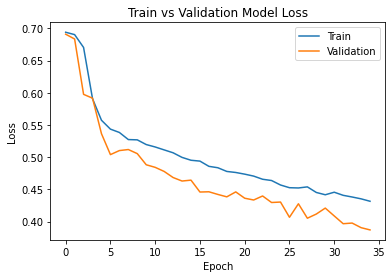

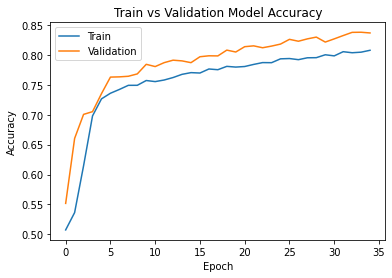


Calculating metrics...
Accuracy: 0.8348
Precision: [0.85334347 0.81810581]
Recall: [0.80856 0.86104]
F1 score: [0.83034834 0.83902401]
Support: [12500 12500]
              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83     12500
         1.0       0.82      0.86      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     25000
weighted avg       0.84      0.83      0.83     25000



In [49]:
def RNN_LSTM_FROZEN_EMBEDDINGS(TEXT, data_train, data_valid, data_test):

  # The number of words in the vocabulary
  input_dim = len(TEXT.vocab)
  # The dimensions of each Glove vector              
  embedding_dim = 100                      
  # The number of hidden neurons
  hidden_dim = 20         
  # The number of output layers
  output_dim = 1                           
  # The number of hidden layers
  num_layers = 2                                        
  # Dropout
  dropout = 0.5                
  # The Glove pre-trained embeddings
  embeddings = TEXT.vocab.vectors
  # Get pad token index from vocab
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

  # Instantiate the model 
  model = LSTM_Model(input_dim, embedding_dim, hidden_dim, output_dim, num_layers, dropout, PAD_IDX)
  print(model)
  print(f'The model has {count_parameters(model):,} trainable parameters\n')
  model.to(device)

  # Replace the initial weights of the embedding layer with the pre-trained embeddings
  model.embedding.weight.data.copy_(embeddings)
  # Initialize <unk> and <pad> both to all zeros 
  UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

  # Setting row in the embedding weights matrix to zero using the token index
  model.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
  model.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)
  #print(model.embedding.weight.data)

  # Initialize the model parameters
  num_epochs = 35
  batch_size = 64
  clip = 2

  set_seed(42)

  # Create the iterators
  train_iterator, valid_iterator, test_iterator = create_iterators(data_train, data_valid, data_test, batch_size)

  # Initialize the optimizer and the loss function
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-4)   
    
  # Define loss function
  loss_function = nn.BCEWithLogitsLoss()
  loss_function = loss_function.to(device)

  best_valid_loss = float('inf')

  # Initialize empty lists to store the values of loss and accuracy for each epoch
  train_accuracies = []
  train_losses = []
  val_accuracies = []
  val_losses = []

  # Freeze the embeddings  
  model.embedding.weight.requires_grad = unfrozen = False

  for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_iterator, optimizer, loss_function, clip)
    validation_loss, validation_accuracy = evaluate(model, valid_iterator, loss_function)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | Frozen: {not unfrozen}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
    print(f'\t Val. Loss: {validation_loss:.3f} |  Val. Acc: {validation_accuracy*100:.2f}%')
      
    if validation_loss < best_valid_loss:
        best_valid_loss = validation_loss
        torch.save(model.state_dict(), 'lstm_model1.pt')

    # Fill the empty lists with the values of accuracy and loss for training and evaluation sets
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

  # Plot the loss vs epochs 
  plt.plot(train_losses)
  plt.plot(val_losses)
  plt.title('Train vs Validation Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Plot the accuracy vs epochs
  plt.plot(train_accuracies)
  plt.plot(val_accuracies)
  plt.title('Train vs Validation Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Evaluate model on the testing set
  predictions, labels = testing(model, test_iterator)

  # Calculate the evaluation metrics on the testing set    
  calculate_metrics(labels, predictions)

# === Run the function ===
RNN_LSTM_FROZEN_EMBEDDINGS(TEXT, train_data, valid_data, test_data)

CNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 20, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 20, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 20, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=60, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 2,524,321 trainable parameters


100%|██████████| 79/79 [00:01<00:00, 76.75it/s]


Epoch: 01 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.725 | Train Acc: 51.72%
	 Val. Loss: 0.679 |  Val. Acc: 53.54%


100%|██████████| 79/79 [00:01<00:00, 77.23it/s]


Epoch: 02 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.689 | Train Acc: 55.25%
	 Val. Loss: 0.658 |  Val. Acc: 65.90%


100%|██████████| 79/79 [00:01<00:00, 76.23it/s]


Epoch: 03 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.671 | Train Acc: 58.47%
	 Val. Loss: 0.639 |  Val. Acc: 71.18%


100%|██████████| 79/79 [00:01<00:00, 77.15it/s]


Epoch: 04 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.648 | Train Acc: 62.72%
	 Val. Loss: 0.619 |  Val. Acc: 73.46%


100%|██████████| 79/79 [00:01<00:00, 76.02it/s]


Epoch: 05 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.629 | Train Acc: 66.06%
	 Val. Loss: 0.598 |  Val. Acc: 74.07%


100%|██████████| 79/79 [00:01<00:00, 75.89it/s]


Epoch: 06 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.610 | Train Acc: 67.81%
	 Val. Loss: 0.576 |  Val. Acc: 75.16%


100%|██████████| 79/79 [00:01<00:00, 76.79it/s]


Epoch: 07 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.592 | Train Acc: 69.79%
	 Val. Loss: 0.556 |  Val. Acc: 76.11%


100%|██████████| 79/79 [00:01<00:00, 77.54it/s]


Epoch: 08 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.575 | Train Acc: 70.73%
	 Val. Loss: 0.538 |  Val. Acc: 76.84%


100%|██████████| 79/79 [00:01<00:00, 76.73it/s]


Epoch: 09 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.565 | Train Acc: 71.49%
	 Val. Loss: 0.521 |  Val. Acc: 77.97%


100%|██████████| 79/79 [00:01<00:00, 76.68it/s]


Epoch: 10 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.554 | Train Acc: 72.19%
	 Val. Loss: 0.507 |  Val. Acc: 78.64%


100%|██████████| 79/79 [00:01<00:00, 77.30it/s]


Epoch: 11 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.550 | Train Acc: 72.40%
	 Val. Loss: 0.496 |  Val. Acc: 79.17%


100%|██████████| 79/79 [00:01<00:00, 77.02it/s]


Epoch: 12 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.540 | Train Acc: 73.32%
	 Val. Loss: 0.484 |  Val. Acc: 79.49%


100%|██████████| 79/79 [00:01<00:00, 76.83it/s]


Epoch: 13 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.531 | Train Acc: 73.90%
	 Val. Loss: 0.475 |  Val. Acc: 80.12%


100%|██████████| 79/79 [00:01<00:00, 76.75it/s]


Epoch: 14 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.528 | Train Acc: 74.08%
	 Val. Loss: 0.468 |  Val. Acc: 80.36%


100%|██████████| 79/79 [00:01<00:00, 76.62it/s]


Epoch: 15 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.518 | Train Acc: 74.86%
	 Val. Loss: 0.461 |  Val. Acc: 80.64%


100%|██████████| 79/79 [00:01<00:00, 76.08it/s]


Epoch: 16 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.515 | Train Acc: 74.86%
	 Val. Loss: 0.456 |  Val. Acc: 80.81%


100%|██████████| 79/79 [00:01<00:00, 75.54it/s]


Epoch: 17 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.512 | Train Acc: 75.24%
	 Val. Loss: 0.451 |  Val. Acc: 81.13%


100%|██████████| 79/79 [00:01<00:00, 76.81it/s]


Epoch: 18 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.509 | Train Acc: 75.44%
	 Val. Loss: 0.446 |  Val. Acc: 81.19%


100%|██████████| 79/79 [00:01<00:00, 76.24it/s]


Epoch: 19 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.507 | Train Acc: 75.32%
	 Val. Loss: 0.442 |  Val. Acc: 81.67%


100%|██████████| 79/79 [00:01<00:00, 77.32it/s]


Epoch: 20 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.500 | Train Acc: 75.94%
	 Val. Loss: 0.440 |  Val. Acc: 81.80%


100%|██████████| 79/79 [00:01<00:00, 76.80it/s]


Epoch: 21 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.500 | Train Acc: 75.87%
	 Val. Loss: 0.437 |  Val. Acc: 81.80%


100%|██████████| 79/79 [00:01<00:00, 77.29it/s]


Epoch: 22 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.495 | Train Acc: 76.53%
	 Val. Loss: 0.433 |  Val. Acc: 82.12%


100%|██████████| 79/79 [00:01<00:00, 76.47it/s]


Epoch: 23 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.497 | Train Acc: 76.01%
	 Val. Loss: 0.432 |  Val. Acc: 82.04%


100%|██████████| 79/79 [00:01<00:00, 76.18it/s]


Epoch: 24 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.491 | Train Acc: 76.29%
	 Val. Loss: 0.429 |  Val. Acc: 82.06%


100%|██████████| 79/79 [00:01<00:00, 76.64it/s]


Epoch: 25 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.496 | Train Acc: 76.12%
	 Val. Loss: 0.427 |  Val. Acc: 82.48%


100%|██████████| 79/79 [00:01<00:00, 75.97it/s]


Epoch: 26 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.487 | Train Acc: 76.86%
	 Val. Loss: 0.425 |  Val. Acc: 82.56%


100%|██████████| 79/79 [00:01<00:00, 76.91it/s]


Epoch: 27 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.487 | Train Acc: 76.69%
	 Val. Loss: 0.423 |  Val. Acc: 82.54%


100%|██████████| 79/79 [00:01<00:00, 76.98it/s]


Epoch: 28 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.488 | Train Acc: 76.66%
	 Val. Loss: 0.421 |  Val. Acc: 82.77%


100%|██████████| 79/79 [00:01<00:00, 77.28it/s]


Epoch: 29 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.486 | Train Acc: 76.82%
	 Val. Loss: 0.419 |  Val. Acc: 82.83%


100%|██████████| 79/79 [00:01<00:00, 77.53it/s]


Epoch: 30 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.481 | Train Acc: 77.49%
	 Val. Loss: 0.417 |  Val. Acc: 82.67%


100%|██████████| 79/79 [00:01<00:00, 77.17it/s]


Epoch: 31 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.485 | Train Acc: 77.03%
	 Val. Loss: 0.415 |  Val. Acc: 83.01%


100%|██████████| 79/79 [00:01<00:00, 77.09it/s]


Epoch: 32 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.482 | Train Acc: 77.06%
	 Val. Loss: 0.415 |  Val. Acc: 83.01%


100%|██████████| 79/79 [00:01<00:00, 75.72it/s]


Epoch: 33 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.480 | Train Acc: 77.18%
	 Val. Loss: 0.414 |  Val. Acc: 82.97%


100%|██████████| 79/79 [00:01<00:00, 76.66it/s]


Epoch: 34 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.477 | Train Acc: 77.78%
	 Val. Loss: 0.413 |  Val. Acc: 83.21%


100%|██████████| 79/79 [00:01<00:00, 75.80it/s]

Epoch: 35 | Epoch Time: 0m 5s | Frozen: True
	Train Loss: 0.476 | Train Acc: 77.63%
	 Val. Loss: 0.411 |  Val. Acc: 83.29%


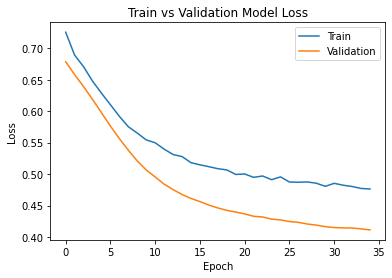

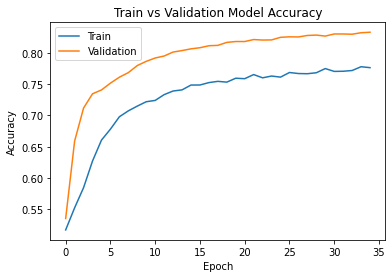


Calculating metrics...
Accuracy: 0.82144
Precision: [0.83776059 0.80662393]
Recall: [0.79728 0.8456 ]
F1 score: [0.81701918 0.82565224]
Support: [12500 12500]
              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82     12500
         1.0       0.81      0.85      0.83     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



In [46]:
def CNN_FROZEN_EMBEDDINGS(TEXT, data_train, data_valid, data_test):

  # The number of words in the vocabulary
  input_dim = len(TEXT.vocab)
  # The dimensions of each Glove vector 
  embedding_dim = 100
  # The number of filters
  num_filters = 20
  # The sizes of the filters
  filter_sizes = [3,4,5]
  # The number of output layers
  output_dim = 1
  # Dropout
  dropout = 0.5
  # The Glove pre-trained embeddings
  embeddings = TEXT.vocab.vectors
  # Get pad token index from vocab
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
  
  model = CNN(input_dim, embedding_dim, num_filters, filter_sizes, output_dim, dropout, PAD_IDX)
  print(model)
  print(f'The model has {count_parameters(model):,} trainable parameters')
  model.to(device)

  # Replace the initial weights of the embedding layer with the pre-trained embeddings
  model.embedding.weight.data.copy_(embeddings)
  # Initialize <unk> and <pad> both to all zeros - irrelevant for sentiment analysis
  UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

  # Setting row in the embedding weights matrix to zero using the token index
  model.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
  model.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)
  #print(model.embedding.weight.data)

  # Initialize the model parameters
  num_epochs = 35
  batch_size = 64
  clip = 2
  
  set_seed(42)

  # Create the iterators
  train_iterator, valid_iterator, test_iterator = create_iterators(data_train, data_valid, data_test, batch_size)

  # Initialize the optimizer and the loss function
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-4)   
    
  # Define loss function
  loss_function = nn.BCEWithLogitsLoss()
  loss_function = loss_function.to(device)

  best_valid_loss = float('inf')

  # Freeze the embeddings
  model.embedding.weight.requires_grad = unfrozen = False

  # Initialize empty lists to store the values of loss and accuracy for each epoch
  train_accuracies = []
  train_losses = []
  val_accuracies = []
  val_losses = []

  for epoch in range(num_epochs):
    
    start_time = time.time()
  
    train_loss, train_accuracy = train(model, train_iterator, optimizer, loss_function, clip)
    validation_loss, validation_accuracy = evaluate(model, valid_iterator, loss_function)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | Frozen: {not unfrozen}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
    print(f'\t Val. Loss: {validation_loss:.3f} |  Val. Acc: {validation_accuracy*100:.2f}%')

    if validation_loss < best_valid_loss:
        epochs_no_improve = 0
        best_valid_loss = validation_loss
        torch.save(model.state_dict(), 'cnn_model1.pt')
      
    # Fill the empty lists with the values of accuracy and loss for training and evaluation sets
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

  # Plot the loss vs epochs 
  plt.plot(train_losses)
  plt.plot(val_losses)
  plt.title('Train vs Validation Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Plot the accuracy vs epochs
  plt.plot(train_accuracies)
  plt.plot(val_accuracies)
  plt.title('Train vs Validation Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Evaluate model on the testing set
  predictions, labels = testing(model, test_iterator)

  # Calculate the evaluation metrics on the testing set    
  calculate_metrics(labels,predictions)

# === Run the function ===
CNN_FROZEN_EMBEDDINGS(TEXT, train_data, valid_data, test_data)

**PART 5: TRAINING AND EVALUATION OF MODELS WITH GLOVE PRE-TRAINED EMBEDDINGS**

LSTM_Model(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (lstm): LSTM(100, 20, num_layers=2, dropout=0.5, bidirectional=True)
  (dense): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 2,529,681 trainable parameters



100%|██████████| 79/79 [00:00<00:00, 86.90it/s]


Epoch: 01 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.694 | Train Acc: 50.53%
	 Val. Loss: 0.691 |  Val. Acc: 55.06%


100%|██████████| 79/79 [00:00<00:00, 86.50it/s]


Epoch: 02 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.691 | Train Acc: 52.94%
	 Val. Loss: 0.684 |  Val. Acc: 65.98%


100%|██████████| 79/79 [00:00<00:00, 88.16it/s] 


Epoch: 03 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.667 | Train Acc: 62.20%
	 Val. Loss: 0.595 |  Val. Acc: 70.19%


100%|██████████| 79/79 [00:00<00:00, 89.24it/s]


Epoch: 04 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.573 | Train Acc: 71.60%
	 Val. Loss: 0.602 |  Val. Acc: 70.77%


100%|██████████| 79/79 [00:00<00:00, 89.17it/s]


Epoch: 05 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.530 | Train Acc: 74.70%
	 Val. Loss: 0.527 |  Val. Acc: 75.87%


100%|██████████| 79/79 [00:00<00:00, 89.19it/s]


Epoch: 06 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.508 | Train Acc: 76.64%
	 Val. Loss: 0.489 |  Val. Acc: 78.09%


100%|██████████| 79/79 [00:00<00:00, 90.44it/s]


Epoch: 07 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.495 | Train Acc: 77.39%
	 Val. Loss: 0.498 |  Val. Acc: 77.87%


100%|██████████| 79/79 [00:00<00:00, 88.99it/s]


Epoch: 08 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.477 | Train Acc: 78.64%
	 Val. Loss: 0.479 |  Val. Acc: 79.15%


100%|██████████| 79/79 [00:00<00:00, 88.45it/s]


Epoch: 09 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.469 | Train Acc: 78.81%
	 Val. Loss: 0.458 |  Val. Acc: 80.00%


100%|██████████| 79/79 [00:00<00:00, 85.53it/s]


Epoch: 10 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.450 | Train Acc: 79.93%
	 Val. Loss: 0.428 |  Val. Acc: 81.69%


100%|██████████| 79/79 [00:00<00:00, 89.62it/s]


Epoch: 11 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.446 | Train Acc: 80.49%
	 Val. Loss: 0.424 |  Val. Acc: 81.35%


100%|██████████| 79/79 [00:00<00:00, 88.42it/s]


Epoch: 12 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.427 | Train Acc: 81.44%
	 Val. Loss: 0.400 |  Val. Acc: 83.29%


100%|██████████| 79/79 [00:00<00:00, 89.21it/s]


Epoch: 13 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.414 | Train Acc: 81.92%
	 Val. Loss: 0.386 |  Val. Acc: 83.96%


100%|██████████| 79/79 [00:00<00:00, 89.04it/s]


Epoch: 14 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.402 | Train Acc: 83.17%
	 Val. Loss: 0.377 |  Val. Acc: 84.67%


100%|██████████| 79/79 [00:00<00:00, 88.01it/s]


Epoch: 15 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.396 | Train Acc: 83.26%
	 Val. Loss: 0.366 |  Val. Acc: 85.30%


100%|██████████| 79/79 [00:00<00:00, 84.56it/s]


Epoch: 16 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.383 | Train Acc: 84.04%
	 Val. Loss: 0.359 |  Val. Acc: 85.36%


100%|██████████| 79/79 [00:00<00:00, 89.89it/s]


Epoch: 17 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.374 | Train Acc: 84.48%
	 Val. Loss: 0.354 |  Val. Acc: 85.82%


100%|██████████| 79/79 [00:00<00:00, 89.60it/s]


Epoch: 18 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.363 | Train Acc: 85.18%
	 Val. Loss: 0.348 |  Val. Acc: 85.92%


100%|██████████| 79/79 [00:00<00:00, 89.87it/s]


Epoch: 19 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.353 | Train Acc: 85.70%
	 Val. Loss: 0.358 |  Val. Acc: 85.64%


100%|██████████| 79/79 [00:00<00:00, 89.59it/s]


Epoch: 20 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.342 | Train Acc: 86.04%
	 Val. Loss: 0.364 |  Val. Acc: 85.78%


100%|██████████| 79/79 [00:00<00:00, 86.02it/s]


Epoch: 21 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.336 | Train Acc: 86.37%
	 Val. Loss: 0.338 |  Val. Acc: 86.59%


100%|██████████| 79/79 [00:00<00:00, 86.92it/s]


Epoch: 22 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.326 | Train Acc: 86.85%
	 Val. Loss: 0.319 |  Val. Acc: 87.38%


100%|██████████| 79/79 [00:00<00:00, 87.34it/s]


Epoch: 23 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.310 | Train Acc: 87.42%
	 Val. Loss: 0.350 |  Val. Acc: 86.85%


100%|██████████| 79/79 [00:00<00:00, 89.12it/s]


Epoch: 24 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.307 | Train Acc: 87.62%
	 Val. Loss: 0.322 |  Val. Acc: 87.38%


100%|██████████| 79/79 [00:00<00:00, 89.90it/s] 


Epoch: 25 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.295 | Train Acc: 88.39%
	 Val. Loss: 0.313 |  Val. Acc: 87.84%


100%|██████████| 79/79 [00:00<00:00, 90.15it/s]


Epoch: 26 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.286 | Train Acc: 88.69%
	 Val. Loss: 0.312 |  Val. Acc: 88.27%


100%|██████████| 79/79 [00:00<00:00, 84.85it/s]


Epoch: 27 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.285 | Train Acc: 88.39%
	 Val. Loss: 0.305 |  Val. Acc: 88.63%


100%|██████████| 79/79 [00:00<00:00, 89.35it/s] 


Epoch: 28 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.279 | Train Acc: 89.17%
	 Val. Loss: 0.295 |  Val. Acc: 89.04%


100%|██████████| 79/79 [00:00<00:00, 84.63it/s]


Epoch: 29 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.265 | Train Acc: 89.68%
	 Val. Loss: 0.304 |  Val. Acc: 88.63%


100%|██████████| 79/79 [00:00<00:00, 89.35it/s] 


Epoch: 30 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.254 | Train Acc: 90.35%
	 Val. Loss: 0.309 |  Val. Acc: 88.96%


100%|██████████| 79/79 [00:00<00:00, 87.42it/s]


Epoch: 31 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.250 | Train Acc: 90.36%
	 Val. Loss: 0.293 |  Val. Acc: 89.22%


100%|██████████| 79/79 [00:00<00:00, 88.71it/s]


Epoch: 32 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.251 | Train Acc: 90.50%
	 Val. Loss: 0.292 |  Val. Acc: 89.02%


100%|██████████| 79/79 [00:00<00:00, 89.85it/s] 


Epoch: 33 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.240 | Train Acc: 90.68%
	 Val. Loss: 0.302 |  Val. Acc: 89.06%


100%|██████████| 79/79 [00:00<00:00, 88.85it/s]


Epoch: 34 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.234 | Train Acc: 91.00%
	 Val. Loss: 0.290 |  Val. Acc: 89.50%


100%|██████████| 79/79 [00:00<00:00, 87.25it/s]

Epoch: 35 | Epoch Time: 0m 8s | Frozen: False
	Train Loss: 0.229 | Train Acc: 91.20%
	 Val. Loss: 0.303 |  Val. Acc: 89.18%


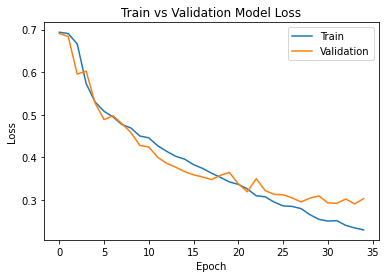

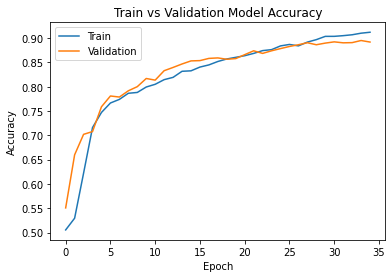


Calculating metrics...
Accuracy: 0.88024
Precision: [0.88287417 0.87764182]
Recall: [0.8768  0.88368]
F1 score: [0.8798266  0.88065056]
Support: [12500 12500]
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     12500
         1.0       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [50]:
def RNN_LSTM_EMBEDDINGS(TEXT, data_train, data_valid, data_test):

  # The number of words in the vocabulary
  input_dim = len(TEXT.vocab)
  # The dimensions of each Glove vector              
  embedding_dim = 100                      
  # The number of hidden neurons
  hidden_dim = 20                  
  # The number of output layers
  output_dim = 1                           
  # The number of hidden layers
  num_layers = 2                                          
  # Dropout
  dropout = 0.5                
  # The Glove pre-trained embeddings
  embeddings = TEXT.vocab.vectors
  # Get pad token index from vocab
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

  # Instantiate the model 
  model = LSTM_Model(input_dim, embedding_dim, hidden_dim, output_dim, num_layers, dropout, PAD_IDX)
  print(model)
  print(f'The model has {count_parameters(model):,} trainable parameters\n')
  model.to(device)

  # Replace the initial weights of the embedding layer with the pre-trained embeddings
  model.embedding.weight.data.copy_(embeddings)
  # Initialize <unk> and <pad> both to all zeros - irrelevant for sentiment analysis
  UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

  # Setting row in the embedding weights matrix to zero using the token index
  model.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
  model.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)
  #print(model.embedding.weight.data)

  # Initialize the model parameters
  num_epochs = 35
  batch_size = 64
  clip = 2

  set_seed(42)

  # Create the iterators
  train_iterator, valid_iterator, test_iterator = create_iterators(data_train, data_valid, data_test, batch_size)

  # Initialize the optimizer and the loss function
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-4)   
    
  # Define loss function
  loss_function = nn.BCEWithLogitsLoss()
  loss_function = loss_function.to(device)

  best_valid_loss = float('inf')

  # Initialize empty lists to store the values of loss and accuracy for each epoch
  train_accuracies = []
  train_losses = []
  val_accuracies = []
  val_losses = []

  # Use the Glove pre-trained embeddings  
  model.embedding.weight.requires_grad = unfrozen = True

  for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_accuracy = train(model, train_iterator, optimizer, loss_function, clip)
    validation_loss, validation_accuracy = evaluate(model, valid_iterator, loss_function)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | Frozen: {not unfrozen}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
    print(f'\t Val. Loss: {validation_loss:.3f} |  Val. Acc: {validation_accuracy*100:.2f}%')
      
    if validation_loss < best_valid_loss:
        best_valid_loss = validation_loss
        torch.save(model.state_dict(), 'lstm_model2.pt')

    # Fill the empty lists with the values of accuracy and loss for training and evaluation sets
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

  # Plot the loss vs epochs 
  plt.plot(train_losses)
  plt.plot(val_losses)
  plt.title('Train vs Validation Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Plot the accuracy vs epochs
  plt.plot(train_accuracies)
  plt.plot(val_accuracies)
  plt.title('Train vs Validation Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Evaluate model on the testing set
  predictions, labels = testing(model, test_iterator)

  # Calculate the evaluation metrics on the testing set    
  calculate_metrics(labels,predictions)

# === Run the function ===
RNN_LSTM_EMBEDDINGS(TEXT, train_data, valid_data, test_data)

CNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 20, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 20, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 20, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=60, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 2,524,321 trainable parameters


100%|██████████| 79/79 [00:01<00:00, 76.99it/s]


Epoch: 01 | Epoch Time: 0m 7s | Frozen: False
	Train Loss: 0.725 | Train Acc: 51.71%
	 Val. Loss: 0.679 |  Val. Acc: 53.44%


100%|██████████| 79/79 [00:01<00:00, 71.80it/s]


Epoch: 02 | Epoch Time: 0m 7s | Frozen: False
	Train Loss: 0.688 | Train Acc: 55.29%
	 Val. Loss: 0.658 |  Val. Acc: 66.52%


100%|██████████| 79/79 [00:01<00:00, 78.58it/s]


Epoch: 03 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.668 | Train Acc: 58.83%
	 Val. Loss: 0.638 |  Val. Acc: 72.25%


100%|██████████| 79/79 [00:01<00:00, 78.10it/s]


Epoch: 04 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.642 | Train Acc: 64.12%
	 Val. Loss: 0.610 |  Val. Acc: 75.02%


100%|██████████| 79/79 [00:01<00:00, 78.39it/s]


Epoch: 05 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.613 | Train Acc: 68.72%
	 Val. Loss: 0.574 |  Val. Acc: 76.70%


100%|██████████| 79/79 [00:01<00:00, 78.15it/s]


Epoch: 06 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.579 | Train Acc: 71.69%
	 Val. Loss: 0.535 |  Val. Acc: 78.70%


100%|██████████| 79/79 [00:01<00:00, 75.71it/s]


Epoch: 07 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.545 | Train Acc: 74.13%
	 Val. Loss: 0.500 |  Val. Acc: 79.09%


100%|██████████| 79/79 [00:01<00:00, 78.04it/s]


Epoch: 08 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.517 | Train Acc: 75.53%
	 Val. Loss: 0.474 |  Val. Acc: 79.69%


100%|██████████| 79/79 [00:01<00:00, 76.84it/s]


Epoch: 09 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.499 | Train Acc: 76.61%
	 Val. Loss: 0.455 |  Val. Acc: 79.81%


100%|██████████| 79/79 [00:01<00:00, 77.42it/s]


Epoch: 10 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.484 | Train Acc: 77.67%
	 Val. Loss: 0.441 |  Val. Acc: 80.54%


100%|██████████| 79/79 [00:01<00:00, 77.11it/s]


Epoch: 11 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.474 | Train Acc: 77.90%
	 Val. Loss: 0.429 |  Val. Acc: 80.80%


100%|██████████| 79/79 [00:01<00:00, 77.47it/s]


Epoch: 12 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.460 | Train Acc: 79.32%
	 Val. Loss: 0.420 |  Val. Acc: 81.45%


100%|██████████| 79/79 [00:01<00:00, 76.97it/s]


Epoch: 13 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.452 | Train Acc: 79.54%
	 Val. Loss: 0.412 |  Val. Acc: 82.04%


100%|██████████| 79/79 [00:01<00:00, 77.23it/s]


Epoch: 14 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.445 | Train Acc: 79.86%
	 Val. Loss: 0.406 |  Val. Acc: 82.30%


100%|██████████| 79/79 [00:01<00:00, 76.46it/s]


Epoch: 15 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.433 | Train Acc: 80.53%
	 Val. Loss: 0.400 |  Val. Acc: 82.85%


100%|██████████| 79/79 [00:01<00:00, 76.48it/s]


Epoch: 16 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.428 | Train Acc: 80.99%
	 Val. Loss: 0.397 |  Val. Acc: 83.05%


100%|██████████| 79/79 [00:01<00:00, 76.76it/s]


Epoch: 17 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.420 | Train Acc: 81.41%
	 Val. Loss: 0.392 |  Val. Acc: 83.19%


100%|██████████| 79/79 [00:01<00:00, 76.79it/s]


Epoch: 18 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.416 | Train Acc: 81.95%
	 Val. Loss: 0.387 |  Val. Acc: 83.41%


100%|██████████| 79/79 [00:01<00:00, 77.10it/s]


Epoch: 19 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.413 | Train Acc: 82.32%
	 Val. Loss: 0.383 |  Val. Acc: 83.98%


100%|██████████| 79/79 [00:01<00:00, 77.33it/s]


Epoch: 20 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.405 | Train Acc: 82.54%
	 Val. Loss: 0.380 |  Val. Acc: 84.14%


100%|██████████| 79/79 [00:01<00:00, 77.20it/s]


Epoch: 21 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.403 | Train Acc: 82.49%
	 Val. Loss: 0.377 |  Val. Acc: 84.30%


100%|██████████| 79/79 [00:01<00:00, 76.56it/s]


Epoch: 22 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.393 | Train Acc: 83.06%
	 Val. Loss: 0.374 |  Val. Acc: 84.43%


100%|██████████| 79/79 [00:01<00:00, 76.61it/s]


Epoch: 23 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.390 | Train Acc: 83.24%
	 Val. Loss: 0.370 |  Val. Acc: 84.30%


100%|██████████| 79/79 [00:01<00:00, 75.33it/s]


Epoch: 24 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.386 | Train Acc: 83.21%
	 Val. Loss: 0.367 |  Val. Acc: 84.65%


100%|██████████| 79/79 [00:01<00:00, 76.15it/s]


Epoch: 25 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.384 | Train Acc: 83.32%
	 Val. Loss: 0.364 |  Val. Acc: 84.79%


100%|██████████| 79/79 [00:01<00:00, 74.84it/s]


Epoch: 26 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.378 | Train Acc: 84.11%
	 Val. Loss: 0.364 |  Val. Acc: 84.85%


100%|██████████| 79/79 [00:01<00:00, 76.54it/s]


Epoch: 27 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.375 | Train Acc: 84.25%
	 Val. Loss: 0.360 |  Val. Acc: 85.05%


100%|██████████| 79/79 [00:01<00:00, 77.18it/s]


Epoch: 28 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.372 | Train Acc: 84.19%
	 Val. Loss: 0.358 |  Val. Acc: 85.42%


100%|██████████| 79/79 [00:01<00:00, 76.61it/s]


Epoch: 29 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.367 | Train Acc: 84.61%
	 Val. Loss: 0.355 |  Val. Acc: 85.46%


100%|██████████| 79/79 [00:01<00:00, 77.12it/s]


Epoch: 30 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.362 | Train Acc: 84.82%
	 Val. Loss: 0.352 |  Val. Acc: 85.52%


100%|██████████| 79/79 [00:01<00:00, 77.34it/s]


Epoch: 31 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.360 | Train Acc: 85.05%
	 Val. Loss: 0.350 |  Val. Acc: 85.76%


100%|██████████| 79/79 [00:01<00:00, 77.02it/s]


Epoch: 32 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.357 | Train Acc: 85.20%
	 Val. Loss: 0.348 |  Val. Acc: 85.74%


100%|██████████| 79/79 [00:01<00:00, 76.22it/s]


Epoch: 33 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.351 | Train Acc: 85.41%
	 Val. Loss: 0.346 |  Val. Acc: 85.90%


100%|██████████| 79/79 [00:01<00:00, 75.65it/s]


Epoch: 34 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.345 | Train Acc: 85.66%
	 Val. Loss: 0.344 |  Val. Acc: 85.92%


100%|██████████| 79/79 [00:01<00:00, 77.12it/s]

Epoch: 35 | Epoch Time: 0m 6s | Frozen: False
	Train Loss: 0.343 | Train Acc: 86.02%
	 Val. Loss: 0.342 |  Val. Acc: 86.12%


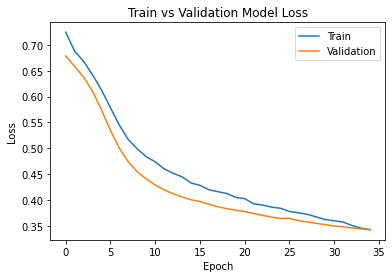

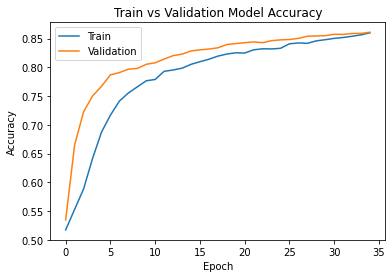


Calculating metrics...
Accuracy: 0.85228
Precision: [0.86085389 0.84410409]
Recall: [0.8404  0.86416]
F1 score: [0.85050399 0.85401431]
Support: [12500 12500]
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85     12500
         1.0       0.84      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [45]:
def CNN_EMBEDDINGS(TEXT, data_train, data_valid, data_test):

  # The number of words in the vocabulary
  input_dim = len(TEXT.vocab)
  # The dimensions of each Glove vector 
  embedding_dim = 100
  # The number of filters
  num_filters = 20
  # The sizes of the filters
  filter_sizes = [3,4,5]
  # The number of output layers
  output_dim = 1
  # Dropout
  dropout = 0.5
  # The Glove pre-trained embeddings
  embeddings = TEXT.vocab.vectors
  # Get pad token index from vocab
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
  
  model = CNN(input_dim, embedding_dim, num_filters, filter_sizes, output_dim, dropout, PAD_IDX)
  print(model)
  print(f'The model has {count_parameters(model):,} trainable parameters')
  model.to(device)

  # Replace the initial weights of the embedding layer with the pre-trained embeddings
  model.embedding.weight.data.copy_(embeddings)
  # Initialize <unk> and <pad> both to all zeros - irrelevant for sentiment analysis
  UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

  # Setting row in the embedding weights matrix to zero using the token index
  model.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
  model.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)
  #print(model.embedding.weight.data)

  # Initialize the model parameters
  num_epochs = 35
  batch_size = 64
  clip = 2

  set_seed(42)

  # Create the iterators
  train_iterator, valid_iterator, test_iterator = create_iterators(data_train, data_valid, data_test, batch_size)

  # Initialize the optimizer and the loss function
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-4)   
    
  # Define loss function
  loss_function = nn.BCEWithLogitsLoss()
  loss_function = loss_function.to(device)

  best_valid_loss = float('inf')

  # Use the Glove pre-trained embeddings  
  model.embedding.weight.requires_grad = unfrozen = True

  # Initialize empty lists to store the values of loss and accuracy for each epoch
  train_accuracies = []
  train_losses = []
  val_accuracies = []
  val_losses = []

  for epoch in range(num_epochs):
    
    start_time = time.time()
  
    train_loss, train_accuracy = train(model, train_iterator, optimizer, loss_function, clip)
    validation_loss, validation_accuracy = evaluate(model, valid_iterator, loss_function)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | Frozen: {not unfrozen}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
    print(f'\t Val. Loss: {validation_loss:.3f} |  Val. Acc: {validation_accuracy*100:.2f}%')

    if validation_loss < best_valid_loss:
        best_valid_loss = validation_loss
        torch.save(model.state_dict(), 'cnn_model2.pt')

    # Fill the empty lists with the values of accuracy and loss for training and evaluation sets
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

  # Plot the loss vs epochs 
  plt.plot(train_losses)
  plt.plot(val_losses)
  plt.title('Train vs Validation Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Plot the accuracy vs epochs
  plt.plot(train_accuracies)
  plt.plot(val_accuracies)
  plt.title('Train vs Validation Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()

  # Evaluate model on the testing set
  predictions, labels = testing(model, test_iterator)

  # Calculate the evaluation metrics on the testing set    
  calculate_metrics(labels,predictions)

# === Run the function ===
CNN_EMBEDDINGS(TEXT, train_data, valid_data, test_data)

**PART 6: USE A PRE-TRAINED MODEL FROM HUGGING FACE AND FINE TUNE IT TO THE IMDB DATASET**

In [ ]:
# Define the pre-trained model from Hugging Face and its tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = 2)
model.to(device)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])


# Define Trainer parameters
def compute_metrics(p):
    
  pred, labels = p
  pred = np.argmax(pred, axis=1)

  accuracy = accuracy_score(y_true=labels, y_pred=pred)
  recall = recall_score(y_true=labels, y_pred=pred)
  precision = precision_score(y_true=labels, y_pred=pred)
  f1 = f1_score(y_true=labels, y_pred=pred)
  return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

In [ ]:
# Get the texts from the training, validation and test data
X_train = list(train_dataframe['review'])
X_val = list(valid_dataframe['review'])
X_test = list(test_dataframe['review'])

y_train = list(train_dataframe['label'])
y_val = list(valid_dataframe['label'])

# Tokenize and pad the data using DistilBert's tokenizer
X_train_tokenized = tokenizer(X_train, padding = True, truncation = True)
X_val_tokenized = tokenizer(X_val, padding = True, truncation = True)
X_test_tokenized = tokenizer(X_test, padding = True, truncation = True)

# Create the Datasets
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized)
print('Training, validation and testing datasets are ready!')

Training, validation and testing datasets are ready!


In [ ]:
# ------ Train the model ------
# Define the Trainer
args = TrainingArguments(
    output_dir = 'output',
    evaluation_strategy = 'steps',
    eval_steps = 500,
    per_device_train_batch_size = 10,
    per_device_eval_batch_size = 8,
    num_train_epochs = 3,
    seed = 42,
    learning_rate = 2e-5,
    weight_decay = 0.01,
    load_best_model_at_end = True)

trainer = Trainer(
    model = model,
    args = args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)])

# Train the pre-trained model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 20000
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 6000


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.399000,0.323400,0.875000,0.876494,0.874751,0.875622
1000,0.349200,0.329207,0.884200,0.905021,0.860040,0.881957
1500,0.320600,0.486559,0.843200,0.776960,0.965408,0.860993
2000,0.302500,0.280257,0.891800,0.893227,0.891451,0.892338
2500,0.213200,0.340442,0.890000,0.931110,0.843738,0.885273
3000,0.236400,0.363311,0.892400,0.880925,0.908946,0.894716
3500,0.226300,0.394082,0.883800,0.847342,0.937972,0.890357


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to output/checkpoint-500
Configuration saved in output/checkpoint-500/config.json
Model weights saved in output/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to output/checkpoint-1000
Configuration saved in output/checkpoint-1000/config.json
Model weights saved in output/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to output/checkpoint-1500
Configuration saved in output/checkpoint-1500/config.json
Model weights saved in output/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Saving model checkpoint to output/checkpoint-2000
Configuration saved in output/checkpoint-2000/config.json
Model weights saved in output/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Nu

TrainOutput(global_step=3500, training_loss=0.2924454585484096, metrics={'train_runtime': 4302.7312, 'train_samples_per_second': 13.945, 'train_steps_per_second': 1.394, 'total_flos': 4636358952960000.0, 'train_loss': 0.2924454585484096, 'epoch': 1.75})

In [ ]:
# ------ Make predictions ------

# Load the trained model
model_path = 'output/checkpoint-2000'
model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels = 2)

# Define the test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

loading configuration file output/checkpoint-2000/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.15.0",
  "vocab_size": 30522
}

loading weights file output/checkpoint-2000/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at output/checkpoint-2000.
If your ta

**PART 7: PRESENTING THE RESULTS**

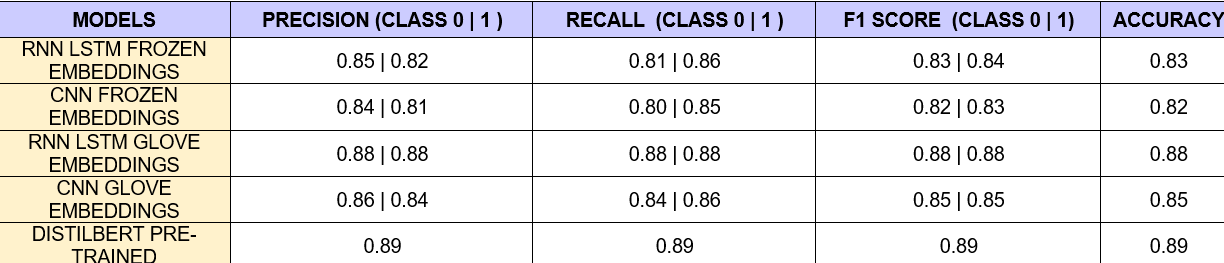

DistilBert: These are the results from the best loaded model at 2000 evaluation steps. 
From the results’ board above, it is evident that the DistilBert model achieved the highest scores of all the models. It also seems that the CNN with the frozen embeddings did not achieve as satisfying results as the other models. It is obvious that with the use of the pre-trained Glove embeddings, the two models performed better, since they achieved higher accuracy and higher F1 score. The RNN with LSTM achieved higher F1 score in both classes and accuracy than the CNN, which makes it the second-best model after the DistilBert. 
The actual performance of the models is more evident in the loss vs epochs and accuracy vs epochs plots. 


During training of the models, I experimented with:

•	The number of stacked RNNs: in order to create a stacked RNN, the minimum number of layers was 2. I used from 2 to 5 layers, but ended up selecting only 2, because I tried to create a very simple model to avoid overfitting.

•	The number of hidden layers: I initially used 128,256,500, but ended up selecting 20 to overcome the serious overfitting problem. According to a rule of thumb presented by Java by Jeff Heaton (2017), “The number of hidden neurons should be between the size of the input layer and the size of the output layer”.  I decided to follow this rule of thumb and limited the number of hidden layers between the input layer size, which were the embeddings’ dimensions (100) and the size of the output layer (1), namely 10,15,20,25,50,55. The final choice was 50 hidden neurons as it offered the best results.

•	The number of filters: I used 20,25,50,55,100, but ended up using 20. 

•	The gradient clipping: I used 1 to 5, but ended up using 2.

•	The dropout probability: I used 0.2 to 0.7, but ended up using 0.5.

•	The learning rate: I used 0.1, 0.01, 0.001, 0.0001, 0.0008, but ended up using 0.0001.

•	The batch size: I used 32, 64, 128 and 256, but ended up using 64. 

•	The number of epochs: I used 5, 10, 20, but ended up using 35.
 
•	Optimizer and loss function: I used the Adam optimizer with weight decay of 1e-4 and the BCEWithLogitsLoss loss function, since it was a binary classification task. 
